# Train and predict on urbansound8k dataset

In this Jupyter Notebook, we will train and predict on UrbanSound8K dataset. There are a few published benchmarks, notebly mentioned in the papers below:

- [Environmental sound classification with convolutional neural networks](http://karol.piczak.com/papers/Piczak2015-ESC-ConvNet.pdf) by Karol J Piczak.
- [Deep convolutional neural networks and data augmentation for environmental sound classification](https://arxiv.org/abs/1608.04363) by Justin Salamon and Juan Pablo Bello
- [Learning from Between-class Examples for Deep Sound Recognition](https://arxiv.org/abs/1711.10282) by Yuji Tokozume, Yoshitaka Ushiku, Tatsuya Harada

And the third one is 

Amonog all of them, one of the state-of-art result is 

This is a Keras/Tensorflow implementation of the 5-layer CNN described in Salamon and Bello's paper (https://arxiv.org/pdf/1608.04363.pdf).

This model (adapted from the original paper) has an accuracy of around 0.63. This is not the best result, as the best result can be replicated based on another paper (http://karol.piczak.com/papers/Piczak2015-ESC-ConvNet.pdf), which is around 64% to 71%. However, the former one takes significantly less time to run (around 20 mins on a K80 GPU card), while the latter model takes around 20 hours to train due to it has two fully connected layers near output and each layer has 5000 hidden units.

We will use the first one as the demo code.

Again, this jupyter notebook is largely based on the Github Repo here: https://github.com/jaron/deep-listening, but re-trained with wider image input


https://arxiv.org/pdf/1711.10282.pdf

In [36]:
import os
import time

import keras
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import tensorflow as tf

keras.backend.clear_session()
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import Adamax
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras import backend as K
from keras.layers.normalization import BatchNormalization

tf.set_random_seed(20171218)
np.random.seed(20171218)


In [2]:
#data_dir = "/mnt/processed"
frames = 150
bands = 150
feature_size = bands * frames
# data_dir = "/home/maxkaz/Downloads/us8k-" + str(bands) + "bands-" + str(frames) + "frames-3channel"
data_dir = "/datadrive/xiaoyzhu/SoundClassification/urbansound8k-classification/code/data/us8k-150bands-150frames-3channel"
num_channels = 3
num_labels = 10


If you're going to run this code with the full data set, this notebook assumes you've already parsed all the files and saved the numpy array to disk. We will load all the training examples (a set of 43722 examples, the first 8 folds), then use fold9 as the validation fold, and use fold 10 as the test fold.


In [3]:
# this will aggregate all the training data 
def load_all_folds(test_fold):
    assert (type(test_fold) == int)
    assert (test_fold > 0 and test_fold < 11)
    subsequent_fold = False

    train_set_range = list(range(1, 11))
    train_set_range.remove(test_fold)
    valid_fold = train_set_range.pop()

    for k in train_set_range:
        fold_name = 'fold' + str(k)
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        # flip the spectrogram for each channel
        loaded_features = np.transpose(loaded_features, (0, 2, 1, 3))
        loaded_labels = np.load(labels_file)
        print("Adding ", fold_name, "New Features: ", loaded_features.shape)

        if subsequent_fold:
            train_x_loaded = np.concatenate((train_x_loaded, loaded_features))
            train_y_loaded = np.concatenate((train_y_loaded, loaded_labels))
        else:
            train_x_loaded = loaded_features
            train_y_loaded = loaded_labels
            subsequent_fold = True

    # use the penultimate fold for validation
    valid_fold_name = 'fold' + str(valid_fold)
    feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
    labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
    valid_x = np.load(feature_file)
    # flip the spectrogram for each channel
    valid_x = np.transpose(valid_x, (0, 2, 1, 3))
    valid_y = np.load(labels_file)

    # and use the last fold for testing
    test_fold_name = 'fold' + str(test_fold)
    feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
    labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
    test_x = np.load(feature_file)
    test_x = np.transpose(test_x, (0, 2, 1, 3))
    test_y = np.load(labels_file)
    return train_x_loaded, train_y_loaded, valid_x, valid_y, test_x, test_y


'\n# this is used to load the folds incrementally\n# TODO: this is not currently used\ndef load_folds(folds):\n    subsequent_fold = False\n    for k in range(len(folds)):\n        fold_name = \'fold\' + str(folds[k])\n        feature_file = os.path.join(data_dir, fold_name + \'_x.npy\')\n        labels_file = os.path.join(data_dir, fold_name + \'_y.npy\')\n        loaded_features = np.load(feature_file)\n        loaded_labels = np.load(labels_file)\n        print(fold_name, "features: ", loaded_features.shape)\n\n        if subsequent_fold:\n            features = np.concatenate((features, loaded_features))\n            labels = np.concatenate((labels, loaded_labels))\n        else:\n            features = loaded_features\n            labels = loaded_labels\n            subsequent_fold = True\n\n    return features, labels\n'

-----

# Training a Convolutional Neural Network with Keras and TensorFlow

First, the imports we need and a few configuration variables.

This method defines some evaluation metrics that will be used to evaluate the performance of a trained model.

In [4]:
def evaluate(model, test_x, test_y):
    y_prob = model.predict(test_x, verbose=0)
    y_pred = np.argmax(y_prob, axis=-1)
    y_true = np.argmax(test_y, 1)

    # evaluate the model
    score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
    print("\nAccuracy = {:.4f}".format(accuracy))
    print("\nError Rate = {:.4f}".format(1. - accuracy))

    # the F-score gives a similiar value to the accuracy score, but useful for cross-checking
    p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print("F-Score = {:.4f}", f)

    return accuracy

This method contains the code that defines the successive layers of our convolutional neural network (CNN) described in this paper by Salamon and Bello: https://arxiv.org/pdf/1608.04363.pdf

In [5]:
def build_model():
    model = Sequential()

    # section 1

    model.add(Convolution2D(filters=32, kernel_size=5,
                            strides=2,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal",
                            input_shape=(frames, bands, num_channels)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(filters=32, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.3))

    # section 2    
    model.add(Convolution2D(filters=64, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(filters=64, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # section 3
    model.add(Convolution2D(filters=128, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(filters=128, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(filters=128, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Convolution2D(filters=128, kernel_size=3,
                            strides=1,
                            padding="same",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # section 4
    model.add(Convolution2D(filters=512, kernel_size=3,
                            strides=1,
                            padding="valid",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Convolution2D(filters=512, kernel_size=1,
                            strides=1,
                            padding="valid",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # section 5
    model.add(Convolution2D(filters=10, kernel_size=1,
                            strides=1,
                            padding="valid",
                            kernel_regularizer=l2(0.0001),
                            kernel_initializer="normal"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(GlobalAveragePooling2D())

    model.add(Activation('softmax'))

    # compile and fit model, reduce epochs if you want a result faster
    # the validation set is used to identify parameter settings (epoch) that achieves 
    # the highest classification accuracy

    return model


### Training on the full data set (intensive) 

This is the training process, it will create a fresh model for each trial, load the next fold of input data, fit it to the model and evaluate the accuracy achieved. When all the input data has been used, we can calculate the average accuracy for all the folds. The parameters used here have been chosen to allow computation to run on a reasonably powered laptop in less than 10 minutes. When running it on an 8-core high-memory cloud instance, more epochs and larger training sets can be used, this will produce greater prediction accuracy, but come at the cost of much greater training time.

In [6]:
# apply scaling factor to a dataset - train, validation or test
def do_scale(x4d, verbose = True):
    """Do scale on the input sequence data.

    Args:
      x34d: ndarray, input sequence data, shape: (n_clips, n_time, n_freq, channel)      
      verbose: boolean

    Returns:
      Scaled input sequence data.
    """
    t1 = time.time()    
    (n_clips, n_time, n_freq, n_channel) = x4d.shape
    x4d_scaled = np.zeros(x4d.shape)
    for channel in range(n_channel):
        x2d = x4d[:,:,:,channel].reshape((n_clips * n_time, n_freq))
        x2d_scaled = scaler_list[channel].transform(x2d)
        x3d_scaled = x2d_scaled.reshape((n_clips, n_time, n_freq))
        x4d_scaled[:,:,:,channel] = x3d_scaled

    if verbose == 1:
        print("Scaling time: %s" % (time.time() - t1,))

    return x4d_scaled


In [13]:
# earlystopping ends training when the validation loss stops improving
model_checkpoint = ModelCheckpoint(
    './sound_classification_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5',
    monitor='val_loss', save_best_only=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-7)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
callbacks = [reduce_lr_on_plateau, early_stopping]

roc_list = []
acc_list = []
# preliniary estimation of performance


for test_fold in range(1, 11):
    print("current test fold:", test_fold)
    model = build_model()

    # compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adamax(0.01))

    train_x, train_y, valid_x, valid_y, test_x, test_y = load_all_folds(test_fold)

    # for each channel, compute scaling factor
    scaler_list = []
    (n_clips, n_time, n_freq, n_channel) = train_x.shape

    for channel in range(n_channel):
        t1 = time.time()
        xtrain_2d = train_x[:, :, :, channel].reshape((n_clips * n_time, n_freq))
        scaler = sklearn.preprocessing.StandardScaler().fit(xtrain_2d)
        # print("Channel %d Mean: %s" % (channel, scaler.mean_,))
        # print("Channel %d Std: %s" % (channel, scaler.scale_,))
        # print("Calculating scaler time: %s" % (time.time() - t1,))
        scaler_list += [scaler]

    train_x = do_scale(train_x)
    valid_x = do_scale(valid_x)
    test_x = do_scale(test_x)
    
    print(train_x.shape)

    # use a batch size to fully utilize GPU power
    history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=callbacks,
                        batch_size=256,
                        epochs=10)
    acc = evaluate(model, test_x, test_y)

    acc_list += [acc]


Adding  fold2 New Features:  (740, 150, 150, 3)
Adding  fold3 New Features:  (810, 150, 150, 3)
Adding  fold4 New Features:  (820, 150, 150, 3)
Adding  fold5 New Features:  (777, 150, 150, 3)
Adding  fold6 New Features:  (703, 150, 150, 3)
Adding  fold7 New Features:  (725, 150, 150, 3)
Adding  fold8 New Features:  (673, 150, 150, 3)
Adding  fold9 New Features:  (696, 150, 150, 3)
Scaling time: 55.06865167617798
Scaling time: 1.0583775043487549
Scaling time: 1.2360680103302002
(5944, 150, 150, 3)
Train on 5944 samples, validate on 709 samples
Epoch 1/10
5944/5944 [==============================] - 25s 4ms/step - loss: 2.2039 - acc: 0.3861 - val_loss: 4.9646 - val_acc: 0.1255
Epoch 2/10
5944/5944 [==============================] - 20s 3ms/step - loss: 1.7230 - acc: 0.5811 - val_loss: 1.8625 - val_acc: 0.5092
Epoch 3/10
5944/5944 [==============================] - 20s 3ms/step - loss: 1.3923 - acc: 0.6824 - val_loss: 2.4853 - val_acc: 0.3329
Epoch 4/10
5944/5944 [========================

820/820 [==============================] - 1s 2ms/step

Accuracy = 0.3463

Error Rate = 0.6537
F-Score = {:.4f} 0.3463414634146341
Adding  fold1 New Features:  (747, 150, 150, 3)
Adding  fold2 New Features:  (740, 150, 150, 3)
Adding  fold3 New Features:  (810, 150, 150, 3)
Adding  fold4 New Features:  (820, 150, 150, 3)
Adding  fold6 New Features:  (703, 150, 150, 3)
Adding  fold7 New Features:  (725, 150, 150, 3)
Adding  fold8 New Features:  (673, 150, 150, 3)
Adding  fold9 New Features:  (696, 150, 150, 3)
Scaling time: 35.791651010513306
Scaling time: 1.1354398727416992
Scaling time: 1.2361857891082764
(5914, 150, 150, 3)
Train on 5914 samples, validate on 709 samples
Epoch 1/10
5914/5914 [==============================] - 26s 4ms/step - loss: 2.2966 - acc: 0.3326 - val_loss: 3.1845 - val_acc: 0.2567
Epoch 2/10
5914/5914 [==============================] - 19s 3ms/step - loss: 1.8623 - acc: 0.5117 - val_loss: 2.5853 - val_acc: 0.2525
Epoch 3/10
5914/5914 [===========================

673/673 [==============================] - 1s 2ms/step

Accuracy = 0.4606

Error Rate = 0.5394
F-Score = {:.4f} 0.4606240713224368
Adding  fold1 New Features:  (747, 150, 150, 3)
Adding  fold2 New Features:  (740, 150, 150, 3)
Adding  fold3 New Features:  (810, 150, 150, 3)
Adding  fold4 New Features:  (820, 150, 150, 3)
Adding  fold5 New Features:  (777, 150, 150, 3)
Adding  fold6 New Features:  (703, 150, 150, 3)
Adding  fold7 New Features:  (725, 150, 150, 3)
Adding  fold8 New Features:  (673, 150, 150, 3)
Scaling time: 41.83431673049927
Scaling time: 1.1230525970458984
Scaling time: 1.0372931957244873
(5995, 150, 150, 3)
Train on 5995 samples, validate on 709 samples
Epoch 1/10
5995/5995 [==============================] - 26s 4ms/step - loss: 2.2067 - acc: 0.3943 - val_loss: 6.6155 - val_acc: 0.1594
Epoch 2/10
5995/5995 [==============================] - 20s 3ms/step - loss: 1.7211 - acc: 0.5678 - val_loss: 2.2986 - val_acc: 0.3427
Epoch 3/10
5995/5995 [============================

In [15]:
acc_array = np.array(acc_list)
print("acc mean %.4f acc std %.4f" % (acc_array.mean(), acc_array.std()))

acc mean 0.4520 acc std 0.0854


709/709 [==============================] - 1s 2ms/step

Accuracy = 0.4866

Error Rate = 0.5134
F-Score = {:.4f} 0.48660084626234135
Showing Confusion Matrix
                    air conditioner            horn        children             dog           drill          engine             gun          hammer           siren           music 
    air conditioner              48               0               0               0               0              33               0              19               0               0 
               horn               1               3               0               0               0               1               0              11               0               0 
           children               1               0              49              12               0              24               0              12               0               0 
                dog               5               0               3              41               0              14    

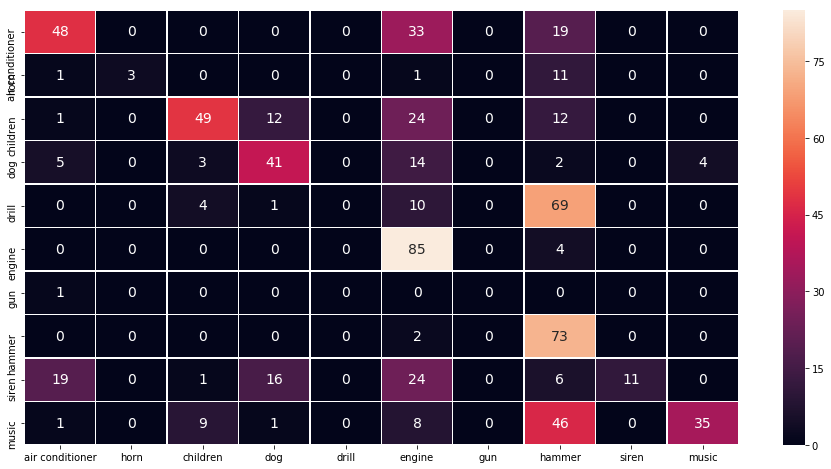

In [16]:
% matplotlib inline
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

#model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], batch_size=32, nb_epoch=50)
acc = evaluate(model, test_x, test_y)  #evaluate(model)

labels = ["air conditioner", "horn", "children", "dog", "drill", "engine", "gun", "hammer", "siren", "music"]
print("Showing Confusion Matrix")
y_prob = model.predict(test_x, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
y_true = np.argmax(test_y, 1)
cm = confusion_matrix(y_true, y_pred)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=' ')
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=' ')
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=' ')
        for j in range(len(labels)):
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=' ')
        print()

print_cm(cm, labels)

df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize=(16, 8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5)


History keys: dict_keys(['val_loss', 'lr', 'val_acc', 'loss', 'acc'])


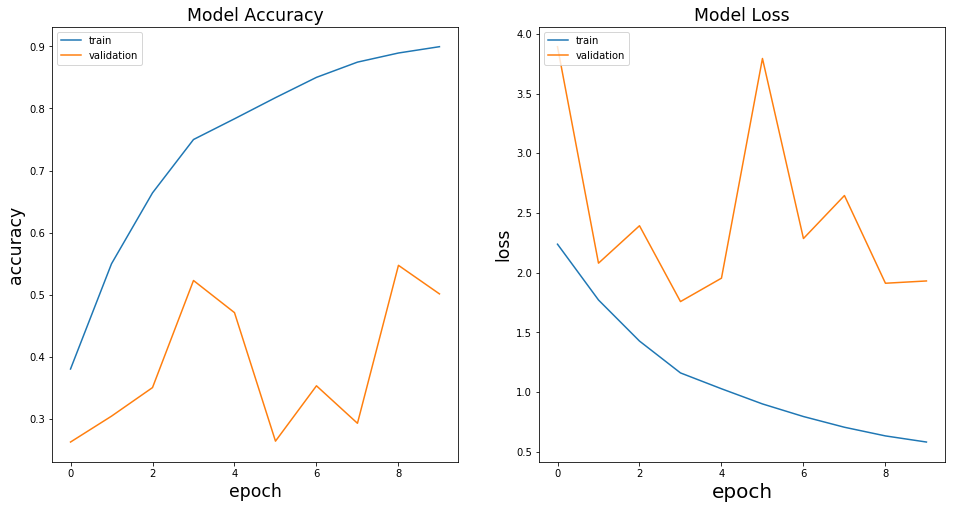

In [33]:

fig = plt.figure(figsize=(16,8))

print("History keys:", (history.history.keys()))
# summarise history for training and validation set accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy',fontsize = 'xx-large')
plt.ylabel('accuracy', fontsize = 'xx-large')
plt.xlabel('epoch', fontsize = 'xx-large')
plt.legend(['train', 'validation'], loc='upper left')

# summarise history for training and validation set loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss',fontsize = 'xx-large')
plt.ylabel('loss', fontsize = 'xx-large')
# plt.tick_params(axis='x', fontsize = 20)
plt.xlabel('epoch', fontsize = 20 )
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Training a more Complex model

In [ ]:

# earlystopping ends training when the validation loss stops improving
model_checkpoint = ModelCheckpoint(
    './sound_classification_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5',
    monitor='val_loss', save_best_only=True)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-7)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
callbacks = [reduce_lr_on_plateau, early_stopping]

roc_list = []
acc_list = []
# preliniary estimation of performance


for test_fold in range(1, 11):
    # clear backend session per http://forums.fast.ai/t/how-could-i-release-gpu-memory-of-keras/2023/13
    K.clear_session()
    print("current test fold:", test_fold)
    model = keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True, weights=None,
                                                                     input_shape=(
                                                                         frames, bands, num_channels),
                                                                     classes=10)

    # compile the model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adamax(0.01))

    train_x, train_y, valid_x, valid_y, test_x, test_y = load_all_folds(test_fold)

    # for each channel, compute scaling factor
    scaler_list = []
    (n_clips, n_time, n_freq, n_channel) = train_x.shape

    for channel in range(n_channel):
        t1 = time.time()
        xtrain_2d = train_x[:, :, :, channel].reshape((n_clips * n_time, n_freq))
        scaler = sklearn.preprocessing.StandardScaler().fit(xtrain_2d)
        # print("Channel %d Mean: %s" % (channel, scaler.mean_,))
        # print("Channel %d Std: %s" % (channel, scaler.scale_,))
        # print("Calculating scaler time: %s" % (time.time() - t1,))
        scaler_list += [scaler]

    train_x = do_scale(train_x)
    valid_x = do_scale(valid_x)
    test_x = do_scale(test_x)
    
    print(train_x.shape)

    # use a batch size to fully utilize GPU power
    history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=callbacks,
                        batch_size=128,
                        epochs=1)
    acc = evaluate(model, test_x, test_y)

    acc_list += [acc]

In [ ]:
acc_array = np.array(acc_list)
print("acc mean %.4f acc std %.4f" % (acc_array.mean(), acc_array.std()))

In [ ]:
% matplotlib inline
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

#model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], batch_size=32, nb_epoch=50)
acc = evaluate(model, test_x, test_y)  #evaluate(model)

labels = ["air conditioner", "horn", "children", "dog", "drill", "engine", "gun", "hammer", "siren", "music"]
print("Showing Confusion Matrix")
y_prob = model.predict(test_x, verbose=0)
y_pred = np.argmax(y_prob, axis=-1)
y_true = np.argmax(test_y, 1)
cm = confusion_matrix(y_true, y_pred)

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=' ')
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=' ')
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=' ')
        for j in range(len(labels)):
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=' ')
        print()

print_cm(cm, labels)

df_cm = pd.DataFrame(cm, labels, labels)
plt.figure(figsize=(16, 8))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5)


In [ ]:

fig = plt.figure(figsize=(16,8))

print("History keys:", (history.history.keys()))
# summarise history for training and validation set accuracy
plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarise history for training and validation set loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()